In [1]:
import os
import gc
import sys
import glob
import copy
import numpy as np
import pandas as pd
import netCDF4 as nc
import multiprocessing as mp
from datetime import datetime, timedelta
from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors
import matplotlib.ticker as mticker
from scipy.stats import gaussian_kde
import datashader as ds
from datashader.mpl_ext import dsshow
# from PLUMBER2_VPD_common_utils import *

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(


In [62]:
def decide_filename(day_time=False, summer_time=False, energy_cor=False,
                    IGBP_type=None, clim_type=None, time_scale=None, standardize=None,
                    country_code=None, selected_by=None, bounds=None, veg_fraction=None,
                    uncertain_type=None, method=None,LAI_range=None,
                    clarify_site={'opt':False,'remove_site':None}):

    # file name
    file_message = ''

    if time_scale != None:
        file_message = file_message + '_' + time_scale

    if IGBP_type != None:
        file_message = file_message + '_PFT='+IGBP_type

    if clim_type != None:
        file_message = file_message + '_CLIM='+clim_type

    if veg_fraction !=None:
        # if selected based on vegetation fraction
        file_message = file_message + '_VF='+str(veg_fraction[0])+'-'+str(veg_fraction[1])

    if LAI_range !=None:
        # if selected based on LAI
        file_message = file_message + '_LAI='+str(LAI_range[0])+'-'+str(LAI_range[1])

    if country_code !=None:
        # if for a country/region
        file_message = file_message +'_'+country_code

    if clarify_site['opt']:
        # if remove 16 sites with problems in observation
        file_message = file_message + '_RM16'

    if day_time:
        # if only daytime
        file_message = file_message + '_DT'

    if standardize != None:
        # if the data is standardized
        file_message = file_message + '_'+standardize

    if selected_by !=None:
        # which criteria used for binning the data
        file_message = file_message +'_'+selected_by

        if len(bounds) >1:
            # percentile
            if bounds[1] > 1:
                file_message = file_message + '_'+str(bounds[0])+'-'+str(bounds[1])+'th'
            else:
                file_message = file_message + '_'+str(bounds[0])+'-'+str(bounds[1])
        elif len(bounds) == 1 :
            # fraction
            if bounds[1] > 1:
                file_message = file_message + '_'+str(bounds[0])+'th'
            else:
                file_message = file_message + '_'+str(bounds[0])

    if method != None:
        file_message = file_message + '_' + method

    if uncertain_type != None and method == 'CRV_bins':
        file_message = file_message + '_' + uncertain_type

    folder_name = 'original'

    if standardize != None:
        folder_name = 'standardized_'+standardize

    if clarify_site['opt']:
        folder_name = folder_name+'_clarify_site'

    return folder_name, file_message

### Setting

In [63]:

# Path of PLUMBER 2 dataset
PLUMBER2_path  = "/g/data/w97/mm3972/scripts/PLUMBER2/LSM_VPD_PLUMBER2/nc_files/"

# site_names, IGBP_types, clim_types, model_names = load_default_list()

# ======================= Setting =======================
var_name       = 'Qle'       #'TVeg'
time_scale     = 'hourly'   #'daily'
selected_by    = 'EF_model' # 'EF_model'
                            # 'EF_obs'
standardize    = None       # 'None'
                            # 'STD_LAI'
                            # 'STD_annual_obs'
                            # 'STD_monthly_obs'
                            # 'STD_monthly_model'
                            # 'STD_daily_obs'
IGBP_type      = None
clim_type      = None
day_time       = True
uncertain_type = 'UCRTN_bootstrap'  
LAI_range      = None
veg_fraction   = None   #[0.7,1]
bounds         = [0.8,1.0] #30
model_in       = 'CABLE-POP-CN'

In [64]:

# ===================== Default pre-processing =======================
clarify_site   = {'opt': True,
                 'remove_site': ['AU-Rig','AU-Rob','AU-Whr','CA-NS1','CA-NS2','CA-NS4','CA-NS5','CA-NS6',
                 'CA-NS7','CA-SF1','CA-SF2','CA-SF3','RU-Che','RU-Zot','UK-PL3','US-SP1']}
models_calc_LAI= ['ORC2_r6593','ORC2_r6593_CO2','ORC3_r7245_NEE','ORC3_r8120','GFDL','SDGVM','QUINCY','NoahMPv401']


if time_scale == 'hourly':
    day_time   = True

energy_cor     = False
if var_name == 'NEE':
    energy_cor = False

# Set regions/country
country_code   = None#'AU'
if country_code != None:
    site_names = load_sites_in_country_list(country_code)

### Read mean curves

In [65]:
method         = 'CRV_bins' 
folder_name, file_message = decide_filename(day_time=day_time, energy_cor=energy_cor, IGBP_type=IGBP_type,
                                            clim_type=clim_type, time_scale=time_scale, standardize=standardize,
                                            country_code=country_code, selected_by=selected_by, bounds=bounds,
                                            veg_fraction=veg_fraction, LAI_range=LAI_range, method=method,
                                            uncertain_type=uncertain_type, clarify_site=clarify_site)
mean_curves = pd.read_csv(f'/g/data/w97/mm3972/scripts/PLUMBER2/LSM_VPD_PLUMBER2/txt/process4_output/{folder_name}/{var_name}{file_message}.csv')

### Read GAM curves

In [66]:
dist_type     = 'Poisson'
method        = 'CRV_fit_GAM_complex' 
uncertain_type = None
folder_name, file_message = decide_filename(day_time=day_time, energy_cor=energy_cor, IGBP_type=IGBP_type,
                                            clim_type=clim_type, time_scale=time_scale, standardize=standardize,
                                            country_code=country_code, selected_by=selected_by, bounds=bounds,
                                            veg_fraction=veg_fraction, LAI_range=LAI_range, method=method,
                                            uncertain_type=uncertain_type, clarify_site=clarify_site)
GAM_curves = pd.read_csv(f'/g/data/w97/mm3972/scripts/PLUMBER2/LSM_VPD_PLUMBER2/txt/process4_output/{folder_name}/{var_name}{file_message}_{dist_type}.csv')

### Read data points 

In [67]:
folder_name, file_message = decide_filename(day_time=day_time, energy_cor=energy_cor, time_scale=time_scale,
                                            standardize=standardize, country_code=country_code,
                                            selected_by=selected_by, bounds=bounds, veg_fraction=veg_fraction,
                                            LAI_range=LAI_range, clarify_site=clarify_site) #
file_input= 'raw_data_'+var_name+'_VPD'+file_message+'.csv'
var_input = pd.read_csv(f'/g/data/w97/mm3972/scripts/PLUMBER2/LSM_VPD_PLUMBER2/txt/process3_output/curves/{file_input}',na_values=[''],
                        usecols=['VPD','model_'+model_in])

### Plotting

In [68]:
def using_datashader(ax, x, y, mean_curves, GAM_curves,model_in):

    df = pd.DataFrame(dict(x=x, y=y))
    dsartist = dsshow(
        df,
        ds.Point("x", "y"),
        ds.count(),
        vmin=0,
        vmax=100,
        norm="linear",
        aspect="auto",
        ax=ax,
    )

    # Plot the line for X_predict and Y_predict
    ax.plot(mean_curves['vpd_series'], mean_curves[model_in+'_vals'], color='red', label='Predicted line')
    ax.fill_between(mean_curves['vpd_series'], mean_curves[model_in+'_bot'], mean_curves[model_in+'_top'], color='red', edgecolor="none", alpha=0.1) #  .


    ax.plot(GAM_curves['vpd_series'], GAM_curves[model_in+'_vals'], color='blue', label='mean line')
    ax.fill_between(GAM_curves['vpd_series'], GAM_curves[model_in+'_bot'], GAM_curves[model_in+'_top'], color='blue', edgecolor="none", alpha=0.1) #  .

    # Add labels and title
    ax.set_xlabel('VPD')
    ax.set_ylabel('Qle')
    ax.set_title('Check the GAM fitted curve')
    # ax.set_xlim(0, 10)  # Set x-axis limits
    # ax.set_ylim(0, 800)  # Set y-axis limits

    # Add legend
    # plt.legend()
    # plt.show()
    
    plt.colorbar(dsartist)



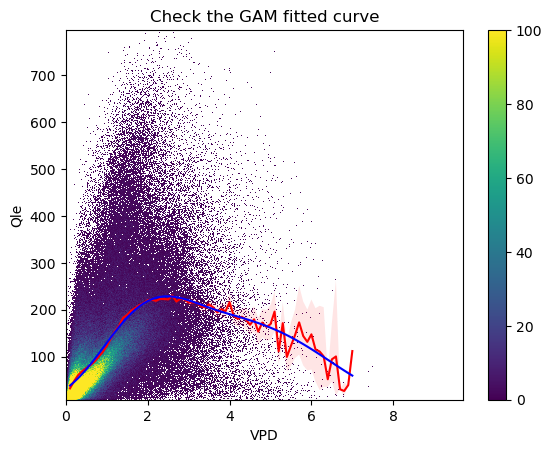

In [69]:
fig, ax = plt.subplots()

using_datashader(ax, var_input['VPD'], var_input['model_'+model_in], mean_curves, GAM_curves, model_in)

In [4]:
var_input = pd.read_csv('/g/data/w97/mm3972/scripts/PLUMBER2/LSM_VPD_PLUMBER2/txt/CMIP6/predicted_CMIP6_DT_Qle_historical_EC-Earth3_CABLE_global_Poisson.csv')

In [ ]:
plt.scatter(var_input['CMIP6'],var_input['CABLE'], s=0.5, facecolors='none', edgecolors='blue',  alpha=0.5, label='data points')

var_input['CMIP6']

0              0.155509
1              0.177593
2              0.199676
3              0.221759
4              0.243843
                ...    
1105015904    10.247778
1105015905    15.229815
1105015906    10.025371
1105015907     2.369815
1105015908    11.575371
Name: CMIP6, Length: 1105015909, dtype: float64